# 画像生成 AI 入門: Python による拡散モデルの理論と実践
## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 23. ControlNet

ControlNet [[Zhang+ CoRR'23]](https://arxiv.org/abs/2302.05543) を用いて Stable Diffusion 等の生成モデルが苦手としている、意図したスタイルや構図の反映を忠実に行う画像生成を実現します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [1]:
!nvidia-smi

Tue Jul 18 13:44:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ
- [xformers](https://github.com/facebookresearch/xformers): accelerate と同様に、Transformer モデルをより効率的に扱い高速な画像生成をサポートするライブラリ

入力する条件によって、画像に対して異なる前処理が必要になるため、以下に画像処理用のライブラリを追加でインストールします:
- [opencv-contrib-python](https://github.com/opencv/opencv-python): 画像処理ライブラリ OpenCV の python 向けライブラリ
- [controlnet-aux](https://github.com/patrickvonplaten/controlnet_aux): ControlNet の前処理モデルが集まったライブラリ

In [2]:
!pip install diffusers==0.16.1
!pip install transformers accelerate xformers
!pip install opencv-contrib-python controlnet_aux

## ControlNet を扱うパイプラインを構築

本セクションでは [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/stable_diffusion/controlnet#diffusers.StableDiffusionControlNetPipeline) を使用して ControlNet パイプラインの動作を確認します。

以下、[ControlNet in 🧨 Diffusers](https://huggingface.co/blog/controlnet) を参考に動作を追っていきます。まず始めに扱う ControlNet は、`Canny model` と呼ばれる canny edge 法を用いたエッジ検出をした画像を元に生成画像の構図を制御するモデルを使用します。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [3]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

今回はフェルメールの有名な絵画「真珠の少女」を使用します。以下のようにして画像をダウンロードします。

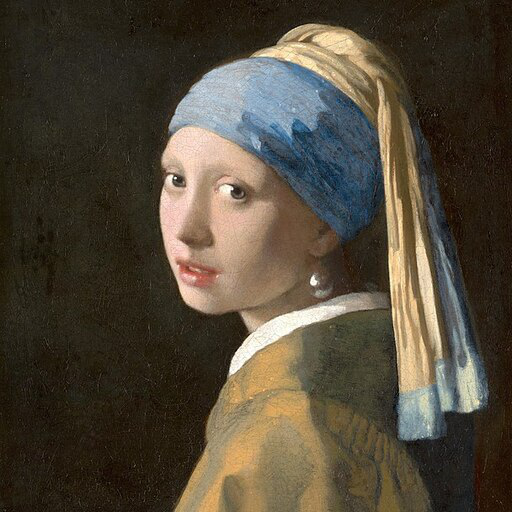

In [4]:
from diffusers.utils import load_image

image_pil = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
image_pil

### Canny エッジ画像の作成

読み込んだ画像に対して Canny エッジ検出を適用します。実行結果を確認すると入力画像から十分なエッジが検出されています。

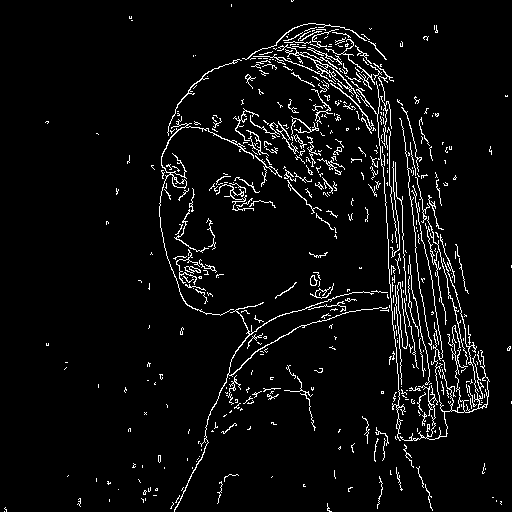

In [5]:
import cv2
import numpy as np

def canny_preprocessor(image: PilImage, low_threshold: int, high_threshold: int) -> PilImage:
    image_arr = np.array(image)

    image_arr = cv2.Canny(image_arr, low_threshold, high_threshold)
    image_arr = image_arr[:, :, None]
    image_arr = np.concatenate((image_arr, image_arr, image_arr), axis=2)

    canny_image = Image.fromarray(image_arr)
    return canny_image

canny_image = canny_preprocessor(image_pil, low_threshold=100, high_threshold=200)
canny_image

### Canny エッジ画像を用いた ControlNet による画像生成

Canny エッジ検出に対応する ControlNet として `lllyasviel/sd-controlnet-canny` を読み込み、更に Stable Diffusion として `runwayml/stable-diffusion-v1-5` を読み込みます。このとき `StableDiffusionControlNetPipeline` を使用して、読み込んだ ControlNet をパイプラインに渡します。

In [6]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

controlnet_model_id = "lllyasviel/sd-controlnet-canny"
controlnet = ControlNetModel.from_pretrained(
    controlnet_model_id, torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Stable Diffusion のデフォルトのノイズスケジューラである [`PNDMScheduler`](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm) を使うかわりに、[`UniPCMultistepScheduler`](https://huggingface.co/docs/diffusers/api/schedulers/unipc) という現在最速のスケジューラを使用してみます。改良されたスケジューラを利用することで、推論時間を劇的に短縮することができます。今回のケースでは、画像生成の品質はそのままに、推論時のステップ数をデフォルトの 50 から 20 に減らすことができました。スケジューラに関する詳しい情報は [こちら](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers) から確認できます。

In [7]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

パイプラインを `.to("cuda")` 等で GPU に直接移動するかわりに、`enable_model_cpu_offload` 関数を呼び出すことで、必要なタイミングで必要な層が GPU 上で動作する CPU offload 機能が有効になります。

Stable Diffusion のような拡散モデルは、推論時に複数のコンポーネントを使用して、それらが順次実行されます。ControlNet を用いた Stable Diffusion の場合、以下の工程があります:
- CLIP テキストエンコーダの使用
- U-Net と ControlNet の使用
- VAE デコーダの使用
- NSFW (Not safe for work) 画像に対する safety checker に使用

ほとんどのコンポーネントは拡散過程中に一度だけ実行されるため、GPU メモリを常に専有する必要はありません。`enable_model_cpu_offload` を使用することで、各コンポーネントが必要なときだけ GPU に読み込まれるようにし、推論速度を減速させること無く、メモリ消費を大幅に抑えることができます。

ここで注意ですが、`enable_model_cpu_offload` を実行するときは、`.to("cuda")` を使って手動でパイプラインを GPU に移動させないでください。CPU offload が有効になると、パイプラインは自動的に GPU への移動を行います。

In [9]:
pipe.enable_model_cpu_offload()

更に、[`xformers` に実装されている `Flash Attention`](https://github.com/facebookresearch/xformers) を有効にします。Flash Attention を用いることで GPU RAM の削減や推論速度の向上が期待できます。

In [11]:
pipe.enable_xformers_memory_efficient_attention()

これで ControlNet を組み込んだ Stable Diffusion パイプラインを実行する準備が整いました。

通常の Stable Diffusion による image-to-image 画像生成と同じようにプロンプトをパイプラインに入力します。しかしながら ControlNet では生成される画像をよりコントロール可能になります。これは Canny エッジ画像を元に、生成される画像の正確な構図をコントールできるからです。

女優や歌手を含む現代の有名人である `サンドラ・オー` (Sandra Oh)、`キム・カーダシアン` (Kim Kardashian)、`リアーナ` (rihanna)、`テイラー・スウィフト` (taylor swift) が、17 世紀に描かれた絵と全く同じポーズをとっている画像を見るのは非常に興味深いと思います。これを実現するためには、単にプロンプトにその有名人の名前を入れるだけで達成できます！

入力するプロンプトを定義して、再現性のための乱数の seed を設定します。

In [8]:
modification_prompt = ", best quality, extremely detailed"
targets = ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]
seed = 19950815

prompts = [target + modification_prompt for target in targets]
generator = [torch.Generator().manual_seed(seed) for _ in range(len(prompts))]

上記の設定を元に、パイプラインを実行して生成画像を表示してみます。

In [13]:
negative_prompt = ["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompts)
assert len(prompts) == len(generator) == len(negative_prompt)

images = pipe(
    prompts,
    image=canny_image,
    negative_prompt=negative_prompt,
    generator=generator,

).images

image_grid(images, rows=2, cols=2)

Output hidden; open in https://colab.research.google.com to view.

### ControlNet と DreamBooth の組み合わせ

ControlNet と fine-tuning 技術は簡単に組み合わせることができます。たとえば
 [DreamBooth](https://arxiv.org/abs/2208.12242) でモデルを fine-tuning し、それを使って自分自身を様々なシーンに描画することができます。

 今回は Mr. ポテトヘッドを例に、ControlNet と DreamBooth の使い方を紹介します。これまでと同様の ControlNet を使用できますが、Stable Diffusion v1.5 を使用するかわりに DreamBooth で fine-tuning した `sd-dreambooth-library/mr-potato-head` を利用します。

 ここで Colab のメモリ容量を気にして、これまで使用したパイプライン `pipe` を削除し、`sd-dreambooth-library/mr-potato-head` を読み込みます。

In [14]:
import gc

del pipe
gc.collect()

300

次に MR. ポテトヘッドを dreambooth で学習させた `sd-dreambooth-library/mr-potato-head` を読み込ませます。

In [15]:
model_id = "sd-dreambooth-library/mr-potato-head"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


では、フェルメールの絵画と同じポーズを取る Mr. ポテトヘッドを生成してみましょう！

  0%|          | 0/50 [00:00<?, ?it/s]

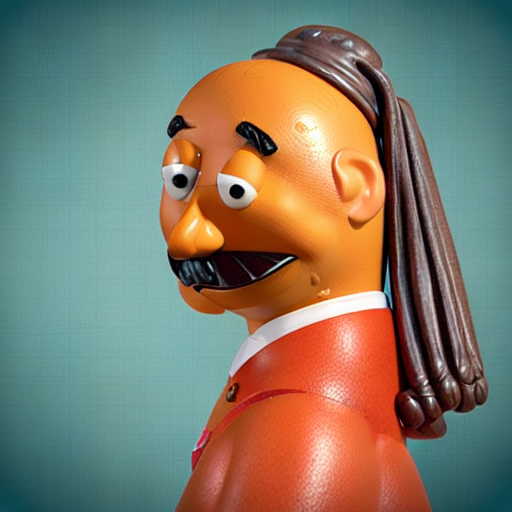

In [16]:
generator = torch.Generator().manual_seed(2)

prompt = "a photo of sks mr potato head, best quality, extremely detailed"

image = pipe(
    prompt,
    image=canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
).images[0]

image

Mr. ポテトヘッドにフェルメールの絵画のポーズを取らせるのはもしかしたら適切ではないかもしれませんが、"彼" はベストを尽くしてフェルメールの絵画になりきってくれています🍟

再度、Colab RAM の節約のために上記で使用したパイプライン `pipe` を削除します。

In [17]:
import gc

del pipe
gc.collect()

52

### 姿勢情報を用いた ControlNet による画像生成

ControlNet は Canny エッジ画像にとどまらず、さまざまな情報による生成画像の制御が可能です。ここでは、ある画像から姿勢情報を取り出し、それを再利用して全く同じポーズの別の画像を生成する方法を紹介します。ここでは Open Pose ControlNet を使って、スーパーヒーローにヨガのやり方を教えてみましょう！

まずはヨガをしている画像をいくつか用意します:

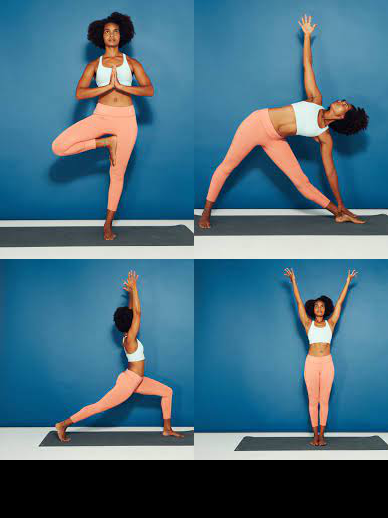

In [9]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url)
    for url in urls
]

image_grid(imgs, 2, 2)

次に `controlnet_aux` 経由で簡単に利用できる `OpenPoseDetector` を使用して、ヨガの姿勢情報を抽出してみましょう。

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


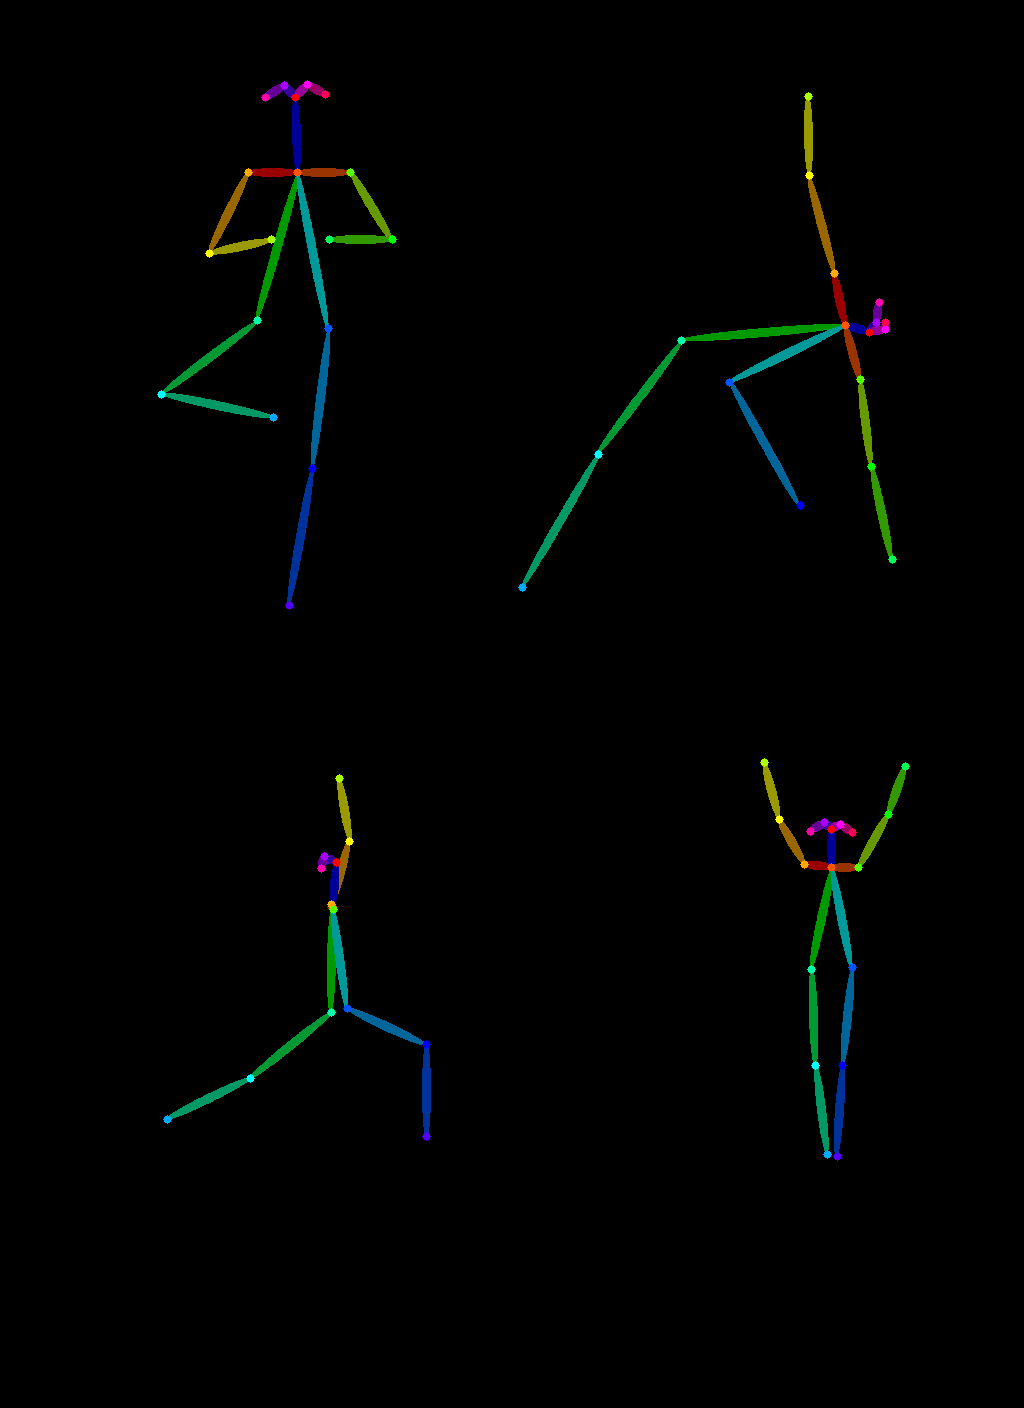

In [10]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [openpose(img) for img in imgs]
image_grid(poses, 2, 2)

姿勢情報を扱えるように事前学習された ControlNet を読み込むにあたって、これまで使っていた Canny エッジ用 ControlNet は削除し、Colab の RAM を節約します。

In [20]:
del controlnet
gc.collect()

24105

上記で用意したヨガのポーズ情報を使って新しい画像を生成するために、Open Pose ControlNet を読み込んでみましょう。

In [21]:
controlnet_model_id = "fusing/stable-diffusion-v1-5-controlnet-openpose"
controlnet = ControlNetModel.from_pretrained(
    controlnet_model_id, torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


では、以下を実行してヨガのポーズを取るヒーローの画像を生成させてみましょう🚀 Now it's yoga time!

In [22]:
nrows = 2
ncols = 2
num_images = nrows * ncols

generator = [torch.Generator().manual_seed(2) for i in range(num_images)]
prompt = "super-hero character, best quality, extremely detailed"
negative_prompt = ["monochrome, lowres, bad anatomy, worst quality, low quality"] * num_images

images = pipe(
    [prompt] * num_images,
    poses,
    negative_prompt=negative_prompt,
    generator=generator,
    num_inference_steps=20,
).images
image_grid(images + poses, nrows, ncols + 2)

Output hidden; open in https://colab.research.google.com to view.

使用したパイプラインと ControlNet を削除しておきます。

In [23]:
del pipe; del controlnet
gc.collect()

584

## ControlNet による複数の条件を組み合わせた画像生成

ControlNet は Canny エッジや姿勢情報単体でも素晴らしい制御能力を発揮しますが、これらを複数組み合わせることも可能です。

条件付けを複数組み合わせるときは、条件どうしが重ならないようにマスクするとより良い生成結果を得やすくなります。今回の例では、姿勢情報の条件がある中央部分に対して、Canny エッジ画像をマスクします。

また `controlnet_conditioning_scales` というパラメータを変化させることで、それぞれの条件を重み付けすることができます。

### Canny エッジ画像の取得

まずは Canny エッジ画像を用いた条件付けの準備をします。以下のようにして元となる画像をダウンロードしてきます。

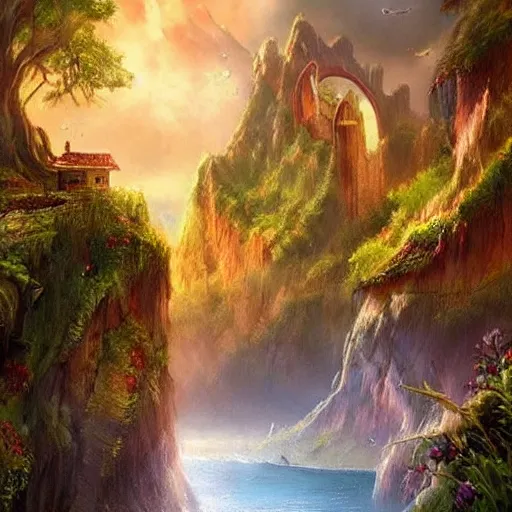

In [11]:
image_pil = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/landscape.png")
image_pil

Canny エッジ画像を生成します。

In [12]:
canny_image = canny_preprocessor(image_pil, low_threshold=100, high_threshold=200)

人物姿勢情報を合成するため、中央部分はゼロ埋めしておきます。

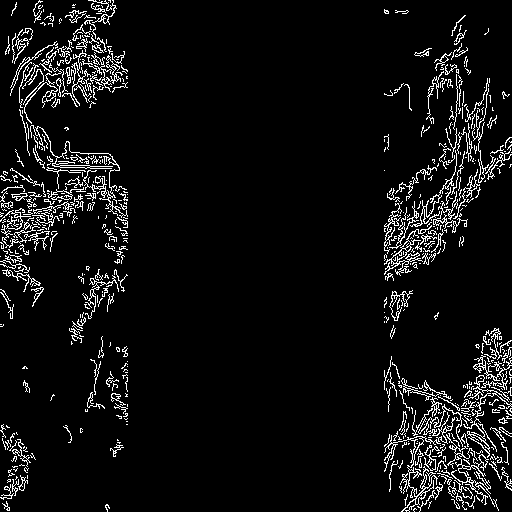

In [13]:
image_arr = np.array(canny_image)
zero_start = image_arr.shape[1] // 4
zero_end = zero_start + image_arr.shape[1] // 2
image_arr[:, zero_start:zero_end] = 0
canny_image = Image.fromarray(image_arr)
canny_image

### 姿勢情報の取得

次に Open Pose を用いた姿勢情報による条件付けの準備をします。以下のようにして対象となる画像をダウンロードします。

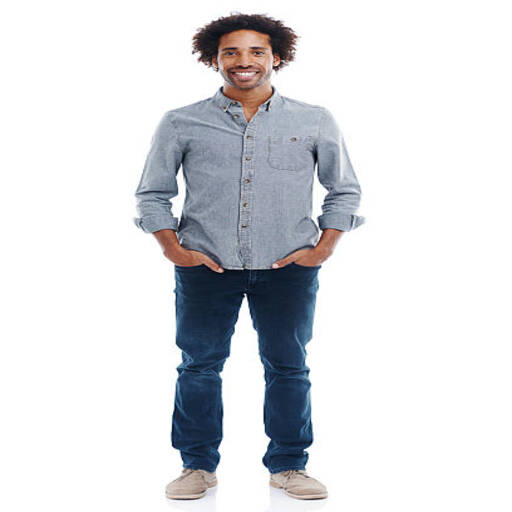

In [14]:
original_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")
original_image

上記の画像を用いて姿勢情報を取得します。

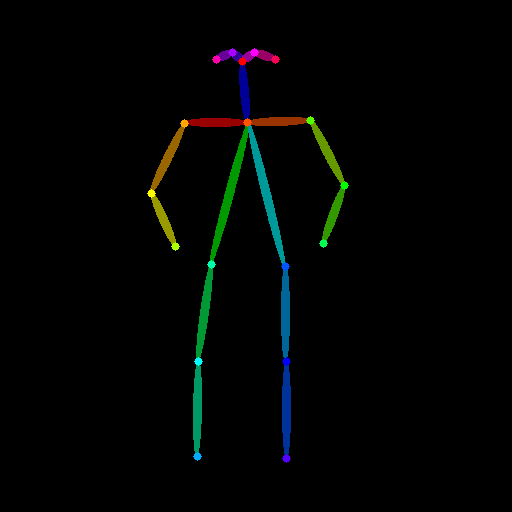

In [15]:
pose_image = openpose(original_image)
pose_image

### 複数の条件による ControlNet を動かす

`StableDiffusionControlNetPipeline` のコンストラクタに ControlNet のリストを渡し、`__call__` に対応する条件のリスト (Canny エッジ画像・姿勢情報画像) を渡します。

In [16]:
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnets, torch_dtype=torch.float16
)
pipe.scheduer = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


では姿勢情報とエッジ情報、更には生成画像に反映してほしくない内容を指定する negative prompt を渡して画像を生成させてみます。

  0%|          | 0/20 [00:00<?, ?it/s]

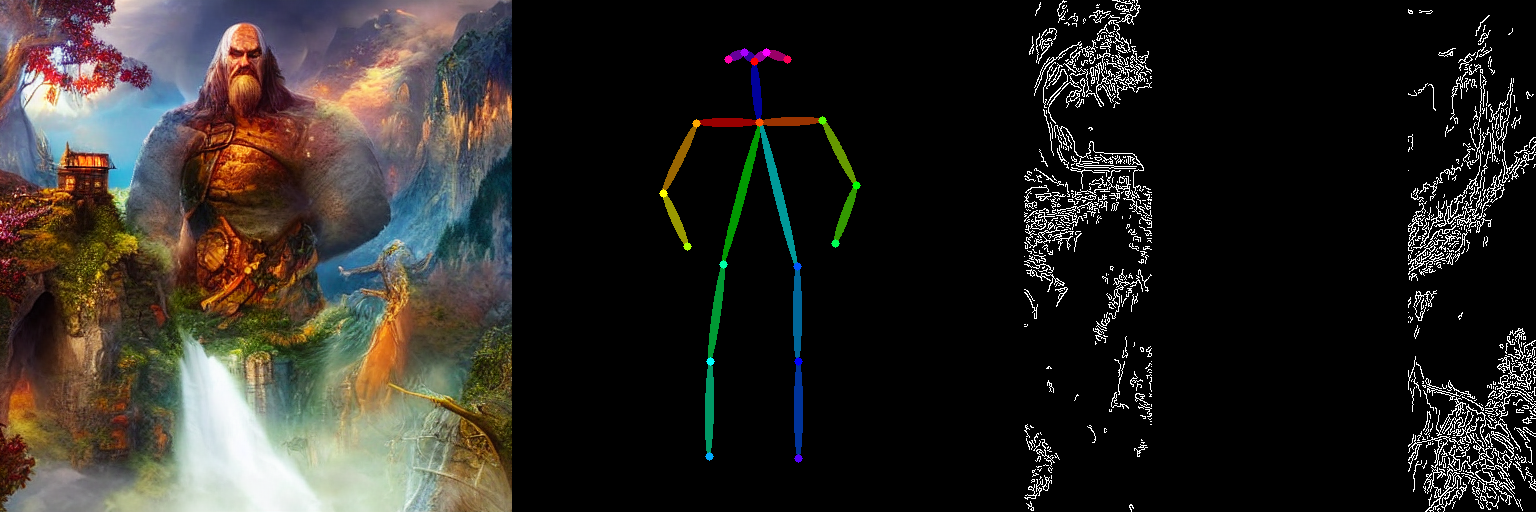

In [17]:
prompt = "a giant standing in a fantasy landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

generator = torch.Generator().manual_seed(seed)

images = [pose_image, canny_image]

image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.8],
).images[0]

image_grid([image, pose_image, canny_image], rows=1, cols=3)

以上のようにして、複数の条件に忠実な画像生成が実現することを確認しました。本実習では複数の事例を通じて `StableDiffusionControlNetPipeline` の様々な面を探求し、diffusers を介した ControlNet が如何に簡単で直感的に動作させることができるかを示しました。しかしながら ControlNet がサポートするすべての条件付けをカバーしたわけではありません。詳細については以下のドキュメントページを確認してください:
- [lllyasviel/sd-controlnet-depth](https://huggingface.co/lllyasviel/sd-controlnet-depth)
- [lllyasviel/sd-controlnet-hed](https://huggingface.co/lllyasviel/sd-controlnet-hed)
- [lllyasviel/sd-controlnet-normal](https://huggingface.co/lllyasviel/sd-controlnet-normal)
- [lllyasviel/sd-controlnet-scribble](https://huggingface.co/lllyasviel/sd-controlnet-scribble)
- [lllyasviel/sd-controlnet-seg](https://huggingface.co/lllyasviel/sd-controlnet-scribble)
- [lllyasviel/sd-controlnet-openpose](https://huggingface.co/lllyasviel/sd-controlnet-openpose)
- [lllyasviel/sd-controlnet-mlsd](https://huggingface.co/lllyasviel/sd-controlnet-mlsd)
- [lllyasviel/sd-controlnet-canny](https://huggingface.co/lllyasviel/sd-controlnet-canny)